# Plot surface currents, wind speeds and salinity
This script is based on Ashu's "Make_profiles.ipynb" notebook in "climatology_analysis_notebooks"

In [54]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
# import the file path location from the forcing_paths.py script
import importlib.util
spec = importlib.util.spec_from_file_location("forcing_paths.py", "/ocean/abhudia/MEOPAR/analysis-ashutosh/scripts/make-hdf5/forcing_paths.py")
paths = importlib.util.module_from_spec(spec)
spec.loader.exec_module(paths)

In [2]:
def timer(func):
    """Decorator function for timing function calls
    """
    def f(*args, **kwargs):
        beganat = time.time()
        rv = func(*args, *kwargs)
        elapsed = time.time() - beganat
        hours = int(elapsed / 3600)
        mins = int((elapsed - (hours*3600))/60)
        secs = int((elapsed - (hours*3600) - (mins*60)))
        print('\nTime elapsed: {}:{}:{}\n'.format(hours, mins, secs))
        return rv
    return f

## Get a list of forcing files to loop through 

In [29]:
# time period to plot up
start_time = '1 dec 2017'
end_time = '7 dec 2017'

# output netcdf to save data to
output_netcdf = 'timeseries_' + ''.join(start_time.split()) + '_' + ''.join(end_time.split()) + '.nc'

### Surface currents

In [37]:
u_paths = paths.salishseacast_paths(parse(start_time), parse(end_time), '/results2/SalishSea/nowcast-green.201806/', 'grid_U')
v_paths = paths.salishseacast_paths(parse(start_time), parse(end_time), '/results2/SalishSea/nowcast-green.201806/', 'grid_V')

### WW3

In [23]:
ww3_paths = paths.ww3_paths(parse(start_time), parse(end_time), '/opp/wwatch3/nowcast/')

### HRDPS

In [24]:
hrdps_paths = paths.hrdps_paths(parse(start_time), parse(end_time), '/results/forcing/atmospheric/GEM2.5/operational/')

## Define grid location from analysis-ashutosh/climatology_analysis_notebooks/Pick grid points.ipynb, we have the locations of the three points chosen as: ((y,x) order)

In [30]:
SoG=(np.array([474]), np.array([252]))

### Loop through the list of files and create a netcdf file of the profile

In [69]:
# create u-velocity vector
first = True
for file_path in u_paths:
    f = xr.open_dataset(file_path).isel(depthu = 0).vozocrtx
    u_now = f.isel(y = 256, x = 268)
    time_now = f.time_centered
    if first is True:
        u_velocity = u_now
        time = time_now
        first = False
    else:
        u_velocity = xr.concat((u_velocity, u_now), dim = 'time_counter')
        time = xr.concat((time, time_now), dim = 'time_counter')

# create v-velocity vector        
first = True
for file_path in v_paths:
    f = xr.open_dataset(file_path).isel(depthv = 0).vomecrty
    v_now = f.isel(y = 256, x = 268)
    if first is True:
        v_velocity = v_now
        first = False
    else:
        v_velocity = xr.concat((v_velocity, v_now), dim = 'time_counter')
        

### Calculate current speed

In [41]:
u = u_velocity.values
v = v_velocity.values
U = (u**2 + v**2)**0.5

### Save current speed to file

In [82]:
# finally, stitch them together and turn the profile into a netcdf file
# The syntax ('time',U) identifies "U" as the "Data variable" dependent on time
current_speed = xr.Dataset({'time': time,'uspd': ('time',U)})

# remove netcdf file if it already exists
if os.path.exists(output_netcdf):
    os.remove(output_netcdf)

# write to netcdf
current_speed.to_netcdf(output_netcdf, format = 'NETCDF4',engine = 'netcdf4')
print(output_netcdf)

timeseries_1dec2017_7dec2017.nc


In [83]:
sfc_current = xr.open_dataset(output_netcdf)
sfc_current

<xarray.Dataset>
Dimensions:        (time: 168, time_counter: 168)
Coordinates:
    depthu         float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2017-12-01T00:30:00 ...
    time           (time_counter) datetime64[ns] ...
Data variables:
    uspd           (time) float32 ...

In [97]:
# loading the netcdf file containing the profile
sfc_current_avg = sfc_current.uspd.rolling(time=12,center=True).mean()

In [95]:
sfc_current_avg


<xarray.DataArray (time: 168)>
array([      nan,       nan,       nan,  0.454797,  0.496368,  0.435232,
        0.404727,  0.400562,  0.403937,  0.385195,  0.326282,  0.326249,
        0.311267,  0.262152,  0.236487,  0.19285 ,  0.183837,  0.195073,
        0.197102,  0.202261,  0.207998,  0.219153,  0.23141 ,  0.209713,
        0.192199,  0.225547,  0.300535,  0.396434,  0.485717,  0.601927,
        0.651992,  0.598803,  0.521361,  0.468356,  0.442674,  0.38545 ,
        0.358878,  0.369314,  0.36829 ,  0.345905,  0.353862,  0.359386,
        0.371644,  0.402466,  0.385993,  0.349802,  0.263489,  0.200532,
        0.159772,  0.168728,  0.261312,  0.369004,  0.460009,  0.536556,
        0.590069,  0.55947 ,  0.480647,  0.434008,  0.426833,  0.418122,
        0.424672,  0.44177 ,  0.437488,  0.427961,  0.441478,  0.445338,
        0.439446,  0.452721,  0.454464,  0.424471,  0.357344,  0.316354,
        0.27186 ,  0.267382,  0.349485,  0.43659 ,  0.504906,  0.560315,
        0.602946,  0

### Plot current speed

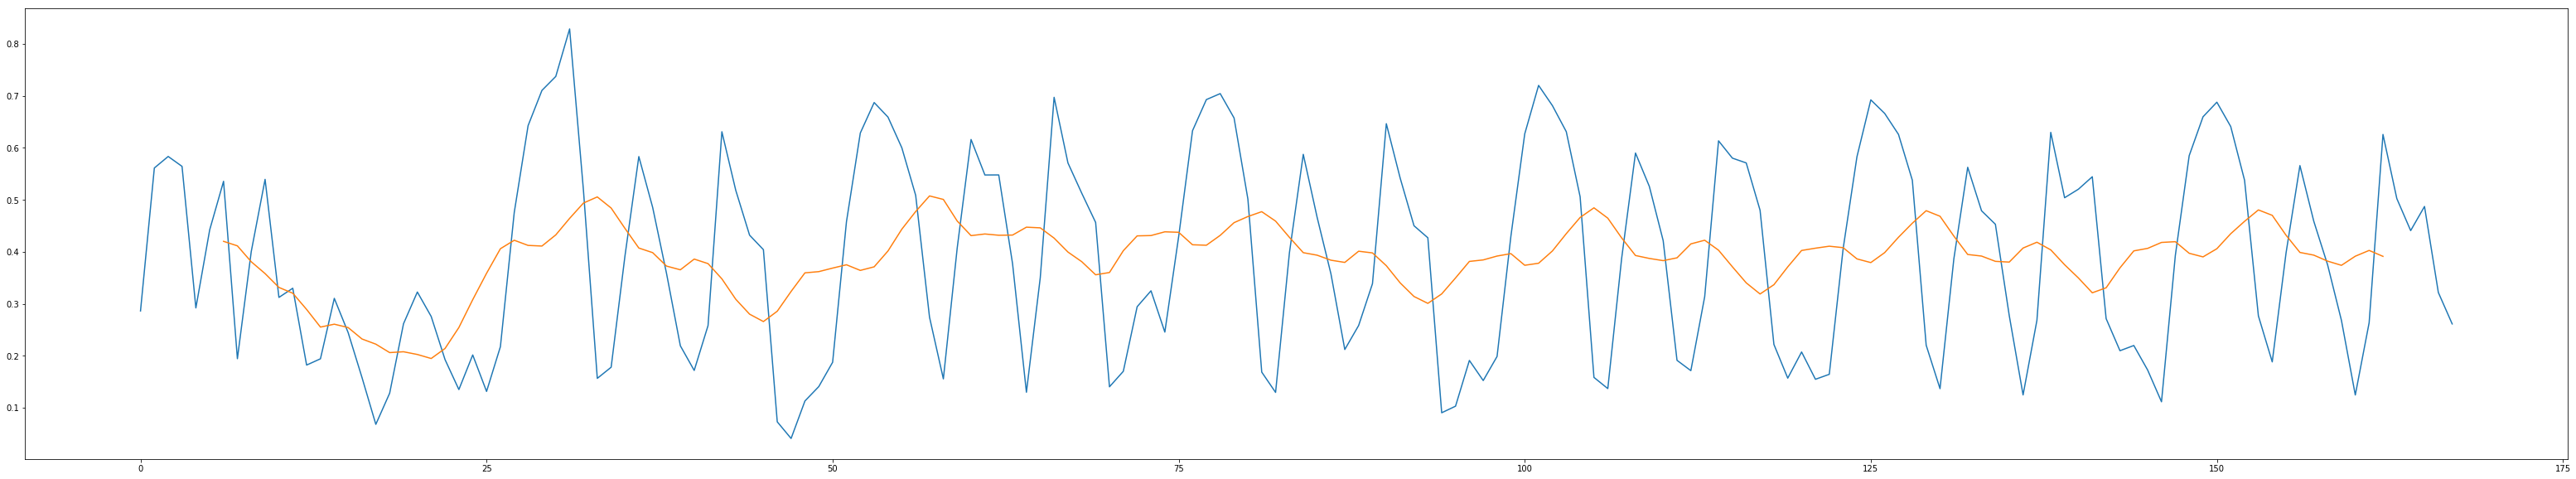

In [99]:
fig = plt.figure(figsize=(55,10))
ax1 = fig.add_subplot(111)
speed_ax = ax1.plot(sfc_current.uspd)
ra_speed_ax = ax1.plot(sfc_current_avg)